# Fase 3 del Proyecto

En esta fase del proyecto se implementarán los modelos de clasificación.

### Carga de Datos

In [8]:
%pip install xgboost imblearn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV


cols = [
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "price", "freight_value", "product_weight_g",
    "product_length_cm", "product_width_cm", "product_height_cm"
]

df = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv", usecols=cols, parse_dates=["order_delivered_customer_date", "order_estimated_delivery_date"])
df.dropna(inplace=True)
df.head()

,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0
1,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0
2,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0
3,2018-08-07 15:27:45,2018-08-13,118.70,22.76,400.0,19.0,13.0,19.0
4,2018-08-17 18:06:29,2018-09-04,159.90,19.22,420.0,24.0,19.0,21.0


### Clasificacion de retrasos de órdenes

In [10]:
df["delivery_diff_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days

def clasificar_retraso(x):
    if x <= 0:
        return "puntual"
    elif x <= 5:
        return "ligero"
    else:
        return "grave"

df["retraso_clase"] = df["delivery_diff_days"].apply(clasificar_retraso)
df["retraso_clase"].value_counts()

retraso_clase
puntual    108171
grave        4337
ligero       3222
Name: count, dtype: int64

### Selección de características

In [11]:
# Seleccionar características
features = ["price", "freight_value", "product_weight_g", "product_length_cm", "product_width_cm", "product_height_cm"]
X = df[features]
y = df["retraso_clase"]

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


### Aplicación de los modelos (Random Forest y XGBoost)

In [12]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Random Forest:

              precision    recall  f1-score   support

       grave       0.42      0.16      0.23       868
      ligero       0.39      0.14      0.21       644
     puntual       0.94      0.99      0.96     21634

    accuracy                           0.93     23146
   macro avg       0.59      0.43      0.47     23146
weighted avg       0.91      0.93      0.92     23146


XGBoost:

              precision    recall  f1-score   support

       grave       0.61      0.02      0.04       868
      ligero       0.80      0.02      0.05       644
     puntual       0.94      1.00      0.97     21634

    accuracy                           0.94     23146
   macro avg       0.78      0.35      0.35     23146
weighted avg       0.92      0.94      0.91     23146



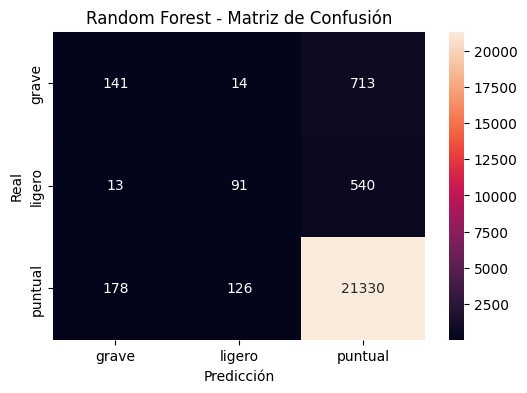

In [13]:
# Predicciones
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

# Reportes
print("Random Forest:\n")
print(classification_report(y_test, rf_preds, target_names=le.classes_))

print("\nXGBoost:\n")
print(classification_report(y_test, xgb_preds, target_names=le.classes_))

# Matriz de confusión - Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Los dos modelos utilizados tienen una alta precision en clase puntual, pero fallan para clasificar correctamente los casos de retraso. Esto se puede visualizar en la matriz de confusión. El modelo predice bien las entregas puntuales con un 99% de acierto pero suele confundir la mayoria de las entregas con retraso como puntuales.

En base a los resultados obtenidos se realizará un balanceo de datos utilizando SMOTE, luego se realizarán modelos con clases ponderadas, se ajustará la métrica objetivo con GridSearchCV y se terminará comparando los resultados.

### Balanceo de Clases

In [14]:
#pip install imbalanced-learn
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("Distribución original:", Counter(y_encoded))
print("Distribución balanceada:", Counter(y_resampled))

Distribución original: Counter({np.int64(2): 108171, np.int64(0): 4337, np.int64(1): 3222})
Distribución balanceada: Counter({np.int64(2): 108171, np.int64(0): 108171, np.int64(1): 108171})


### Random Forest con Balanceo y GridSearch

In [15]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_rf.fit(X_resampled, y_resampled)

print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor score f1_macro:", grid_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score f1_macro: 0.9179474416431143


In [16]:
counts = Counter(y_resampled)
total = sum(counts.values())
scale_weights = {k: total / v for k, v in counts.items()}

weights_list = [scale_weights[i] for i in sorted(scale_weights.keys())]

# Grid de XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.1, 0.3],
}

xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_xgb.fit(X_resampled, y_resampled)

print("Mejores parámetros:", grid_xgb.best_params_)
print("Mejor score f1_macro:", grid_xgb.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
Mejor score f1_macro: 0.8198776740764334


In [17]:
rf_best = grid_rf.best_estimator_
xgb_best = grid_xgb.best_estimator_

rf_preds = rf_best.predict(X_test)
xgb_preds = xgb_best.predict(X_test)

print("Random Forest mejorado:\n", classification_report(y_test, rf_preds, target_names=le.classes_))
print("\nXGBoost mejorado:\n", classification_report(y_test, xgb_preds, target_names=le.classes_))


Random Forest mejorado:
               precision    recall  f1-score   support

       grave       0.70      0.78      0.74       868
      ligero       0.66      0.72      0.69       644
     puntual       0.98      0.98      0.98     21634

    accuracy                           0.96     23146
   macro avg       0.78      0.83      0.80     23146
weighted avg       0.96      0.96      0.96     23146


XGBoost mejorado:
               precision    recall  f1-score   support

       grave       0.25      0.37      0.30       868
      ligero       0.23      0.31      0.26       644
     puntual       0.96      0.93      0.94     21634

    accuracy                           0.89     23146
   macro avg       0.48      0.53      0.50     23146
weighted avg       0.91      0.89      0.90     23146



La comparación entre los modelos muestra mejoras claras al aplicar las técniacas de balanceo, ponderación de clases y ajuste de parámetros. El modelo de Random Forest mostró una mejora para predecir los casos de retraso tanto graves como ligeros. La clase 'grave' pasó de tener una recuperación del 16% al 78% y la clase 'ligero' pasó de un 14% a 72%. Además se mantiene una precisión alta para las entregas puntuales. Indicando que el modelo distingue mejor entre los distintos tipos de entrega.

Por otro lado, XGBoost a pesar de presentar una ligera mejora a comparación se su versión anterior, sigue teniendo dificultades para identificar bien las clases minoritarias. Su precisión y recall en clases grave y ligero son bajos lo que suele predecir la clase mayoritaria, puntual.

Finalmente, los resultados del GridSearchCV muestran que Random Forest logró un f1_macro score de 0.91, superando ampliamente a XGBoost, que obtuvo 0.81. Esto confirma que, con los ajustes adecuados, Random Forest es el modelo más robusto para este problema.

In [22]:
df.head(5)

,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_diff_days,retraso_clase,volumen_cm3,costo_peso,costo_volumen,dia_semana_estimada,mes_estimada,diferencia_precio_flete
0,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0,-8,puntual,1976.0,0.017440,0.004413,2,10,21.27
1,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0,-8,puntual,1976.0,0.017440,0.004413,2,10,21.27
2,2017-10-10 21:25:13,2017-10-18,29.99,8.72,500.0,19.0,8.0,13.0,-8,puntual,1976.0,0.017440,0.004413,2,10,21.27
3,2018-08-07 15:27:45,2018-08-13,118.70,22.76,400.0,19.0,13.0,19.0,-6,puntual,4693.0,0.056900,0.004850,0,8,95.94
4,2018-08-17 18:06:29,2018-09-04,159.90,19.22,420.0,24.0,19.0,21.0,-18,puntual,9576.0,0.045762,0.002007,1,9,140.68


F1 Macro (Random Forest - Validación Cruzada): [0.40162937 0.39848176 0.36880878 0.39192117 0.39991553]
Promedio F1 Macro: 0.39215132170605604
ROC AUC (Random Forest - macro): 0.8720589307708931


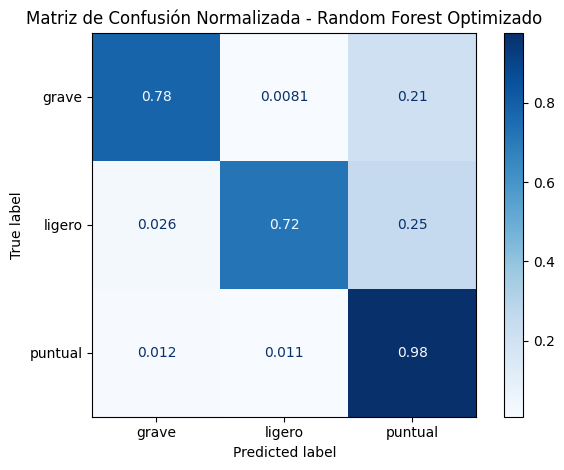

Reporte de Clasificación - Random Forest:
               precision    recall  f1-score   support

       grave       0.70      0.78      0.74       868
      ligero       0.66      0.72      0.69       644
     puntual       0.98      0.98      0.98     21634

    accuracy                           0.96     23146
   macro avg       0.78      0.83      0.80     23146
weighted avg       0.96      0.96      0.96     23146



In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# === Validación cruzada con el modelo Random Forest optimizado ===
cv_scores_rf = cross_val_score(
    rf_best, X_test, y_test, cv=5, scoring='f1_macro'
)
print("F1 Macro (Random Forest - Validación Cruzada):", cv_scores_rf)
print("Promedio F1 Macro:", cv_scores_rf.mean())

# === AUC-ROC Multiclase ===
# Binarizar etiquetas reales y predichas para ROC AUC multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
rf_preds_bin = label_binarize(rf_preds, classes=[0, 1, 2])

roc_auc = roc_auc_score(y_test_bin, rf_preds_bin, average="macro")
print("ROC AUC (Random Forest - macro):", roc_auc)

# === Matriz de Confusión Normalizada ===
ConfusionMatrixDisplay.from_predictions(
    y_test, rf_preds, display_labels=le.classes_,
    cmap="Blues", normalize="true"
)
plt.title("Matriz de Confusión Normalizada - Random Forest Optimizado")
plt.tight_layout()
plt.show()

# === Reporte de Clasificación ===
reporte_rf = classification_report(y_test, rf_preds, target_names=le.classes_)
print("Reporte de Clasificación - Random Forest:\n", reporte_rf)

# Guardar el reporte en archivo
with open("reporte_rf.txt", "w") as f:
    f.write(reporte_rf)

In [ ]:
from geopy.distance import geodesic

# Cargar datasets
customers = pd.read_csv("../data_clean/olist_customers_dataset_clean.csv")
sellers = pd.read_csv("../data_clean/olist_sellers_dataset_clean.csv")
geolocation = pd.read_csv("../data_clean/olist_geolocation_dataset_clean.csv")
orders = pd.read_csv("../data_clean/olist_orders_dataset_clean.csv", parse_dates=["order_delivered_customer_date", "order_estimated_delivery_date"])
order_items = pd.read_csv("../data_clean/olist_order_items_dataset_clean.csv")


In [32]:
geo_coords = geolocation.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean()


In [33]:
customers["lat_cliente"] = customers["customer_zip_code_prefix"].map(geo_coords["geolocation_lat"])
customers["lng_cliente"] = customers["customer_zip_code_prefix"].map(geo_coords["geolocation_lng"])

sellers["lat_vendedor"] = sellers["seller_zip_code_prefix"].map(geo_coords["geolocation_lat"])
sellers["lng_vendedor"] = sellers["seller_zip_code_prefix"].map(geo_coords["geolocation_lng"])


In [34]:
orders_customers = pd.merge(orders, customers, on="customer_id", how="left")
orders_items = pd.merge(order_items, sellers, on="seller_id", how="left")
orders_full = pd.merge(orders_customers, orders_items, on="order_id", how="inner")


In [35]:
def calcular_distancia(row):
    origen = (row["lat_vendedor"], row["lng_vendedor"])
    destino = (row["lat_cliente"], row["lng_cliente"])
    if pd.isnull(origen[0]) or pd.isnull(origen[1]) or pd.isnull(destino[0]) or pd.isnull(destino[1]):
        return None
    return geodesic(origen, destino).kilometers

orders_full["distancia_km"] = orders_full.apply(calcular_distancia, axis=1)


In [38]:
distancias_df = orders_full[["order_id", "distancia_km"]].dropna().drop_duplicates()
distancias_df.to_csv("../data_clean/ordenes_con_distancia.csv", index=False)


In [39]:
distancias = pd.read_csv("../data_clean/ordenes_con_distancia.csv")

In [40]:
df = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv", parse_dates=["order_delivered_customer_date", "order_estimated_delivery_date"])
df.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)


In [41]:
df = pd.merge(df, distancias, on="order_id", how="left")

In [ ]:
df["delivery_diff_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["retraso_clase"] = df["delivery_diff_days"].apply(clasificar_retraso)

In [43]:
features = [
    "price", "freight_value", "product_weight_g",
    "product_length_cm", "product_width_cm", "product_height_cm",
    "distancia_km"  # nueva variable
]
df = df.dropna(subset=features + ["retraso_clase"])
X = df[features]
y = df["retraso_clase"]


In [ ]:
# Cargar dataset base
df = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv", parse_dates=["order_delivered_customer_date", "order_estimated_delivery_date"])
df.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)

# Cargar distancias
distancias = pd.read_csv("../data_clean/ordenes_con_distancia.csv")

# Unir por order_id
df = pd.merge(df, distancias, on="order_id", how="left")


In [ ]:
df["delivery_diff_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["retraso_clase"] = df["delivery_diff_days"].apply(clasificar_retraso)


In [ ]:
features = [
    "price", "freight_value", "product_weight_g",
    "product_length_cm", "product_width_cm", "product_height_cm",
    "distancia_km"
]

df = df.dropna(subset=features + ["retraso_clase"])
X = df[features]
y = df["retraso_clase"]

# Codificación
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribución original:", Counter(y_train))
print("Distribución balanceada:", Counter(y_resampled))


Distribución original: Counter({np.int64(2): 88705, np.int64(0): 3451, np.int64(1): 2575})
Distribución balanceada: Counter({np.int64(1): 88705, np.int64(2): 88705, np.int64(0): 88705})


In [48]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_rf.fit(X_resampled, y_resampled)

print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor f1_macro:", grid_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mejor f1_macro: 0.9575564545051741


In [49]:
rf_best = grid_rf.best_estimator_
rf_preds = rf_best.predict(X_test)

print("Reporte final con distancia:\n")
print(classification_report(y_test, rf_preds, target_names=le.classes_))


Reporte final con distancia:

              precision    recall  f1-score   support

       grave       0.30      0.23      0.26       863
      ligero       0.31      0.22      0.26       644
     puntual       0.95      0.97      0.96     22176

    accuracy                           0.92     23683
   macro avg       0.52      0.47      0.49     23683
weighted avg       0.91      0.92      0.91     23683



<Figure size 1000x600 with 0 Axes>

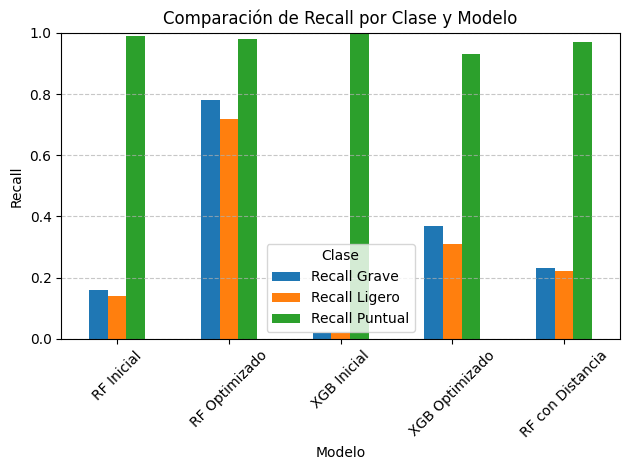

In [50]:
# Datos de performance
model_data = {
    "Modelo": ["RF Inicial", "RF Optimizado", "XGB Inicial", "XGB Optimizado", "RF con Distancia"],
    "Recall Grave": [0.16, 0.78, 0.02, 0.37, 0.23],
    "Recall Ligero": [0.14, 0.72, 0.02, 0.31, 0.22],
    "Recall Puntual": [0.99, 0.98, 1.00, 0.93, 0.97]
}

# Crear DataFrame
df_models = pd.DataFrame(model_data)

# Crear gráfico
plt.figure(figsize=(10, 6))
df_models.set_index("Modelo")[["Recall Grave", "Recall Ligero", "Recall Puntual"]].plot(kind="bar")
plt.title("Comparación de Recall por Clase y Modelo")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Clase")
plt.tight_layout()
plt.show()


**Clase `puntual` (barra verde):**
Todos los modelos presentan un recall muy alto (mayor a 0.9), lo que indica que predicen correctamente la mayoría de las entregas puntuales. Esto es coherente con el desbalance de clases, donde la mayoría de los casos pertenecen a esta categoría.

**Clases `grave` (azul) y `ligero` (naranja):**
En los modelos iniciales (Random Forest y XGBoost), el recall para estas clases es muy bajo, especialmente en XGBoost donde casi no logra identificar correctamente estos casos.
El modelo Random Forest optimizado es el único que logra recalls altos para ambas clases minoritarias (`grave`: 0.78, `ligero`: 0.72), gracias a las técnicas de balanceo (SMOTE), ponderación de clases y ajuste de hiperparámetros.

XGBoost optimizado presenta una ligera mejora respecto a su versión inicial, pero aún muestra un rendimiento inferior al de Random Forest.
Por su parte, el modelo de Random Forest con la variable `distancia` no mejora los resultados respecto al modelo optimizado sin esta variable; incluso, se observa una caída en el recall de las clases `grave` y `ligero`. Esto sugiere que la distancia geográfica no aporta información significativa para mejorar la predicción del tipo de entrega.


Por lo tanto, Random Forest optimizado es el modelo más balanceado y efectivo para este problema. Los demás modelos tienden a favorecer la clase mayoritaria y fallan al clasificar correctamente los casos con retraso. La inclusión de la variable `distancia_km` no aporta mejoras significativas al rendimiento del modelo.
